## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit.

In [51]:
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from functools import reduce

import torch
import torchvision
from torchvision.datasets import MNIST
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim

from scipy.ndimage import zoom
import wandb
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from datetime import datetime
# torch.cuda.is_available()

In [52]:
# TRAINING AND EVALUATION FUNCTIONS 
# Function to train one epoch
def train_epoch(
        model: nn.Module, 
        data: DataLoader, 
        class_names: list, 
        epoch: int, 
        opt: optim.Optimizer, 
        device="cuda"
    ):

    model.train()

    losses = []
    gts = []
    preds = []

    # Zero out the gradients
    opt.zero_grad()
    
    for (i, (xs, ys)) in enumerate(tqdm(data, desc=f"Training epoch {epoch}", leave=True)):
        # Get the input and target data and move it to the device
        xs, ys = xs.to(device), ys.to(device)

        # Zero out the gradients
        opt.zero_grad()

        # Forward pass
        logits = model(xs)

        # Get the predicted classes
        pred = torch.argmax(logits, 1)
        
        # Compute the cross entropy loss
        loss = F.cross_entropy(logits, ys)

        # Backward pass
        loss.backward()

        # Update the model parameters
        opt.step()

        # Append the loss
        losses.append(loss.item())
        preds.extend(pred.detach().cpu().numpy())
        gts.extend(ys.detach().cpu().numpy())

    # Compute the accuracy and classification report
    accuracy = accuracy_score(gts, preds)
    class_report = classification_report(gts, preds, zero_division=0, digits=3, output_dict=True)
    class_report_db = classification_report(gts, preds, zero_division=0, digits=3).splitlines()

    report_table = []
    for line in class_report_db[2:(len(class_names)+2)]:
       report_table.append(line.split())

    # Log the results
    loss = np.mean(losses)
    wandb.log({
        "train/epoch": epoch, 
        "train/loss": loss, 
        "train/accuracy": accuracy, 
        "train_class_rep/classification_report": class_report,
        "train/confusion_matrix": wandb.plot.confusion_matrix(y_true=gts, preds=preds, class_names=class_names),
        "train/classification_report": wandb.Table(data=report_table, columns=["Class", "Precision", "Recall", "F1-score", "Support"])
        },
        step=epoch)

    # Return the average loss, accuracy and classification report
    return loss, accuracy, class_report

# Function to evaluate one epoch
def evaluate_epoch(
        model: nn.Module, 
        data: DataLoader, 
        class_names: list, 
        epoch: int, 
        device="cuda"
    ):

    model.eval()

    losses = []
    preds = []
    gts = []
    # Disable gradient computation for evaluation
    with torch.no_grad():
        for (_, (xs, ys)) in enumerate(tqdm(data, desc=f"Evaluating", leave=True)):
            # Get the input and target data and move it to the device
            xs, ys = xs.to(device), ys.to(device)

            # Forward pass
            logits = model(xs)

            # Compute the cross entropy loss
            loss = F.cross_entropy(logits, ys)

            # Get the predicted classes
            pred = torch.argmax(logits, 1)

            # Append the loss, predictions and ground truths
            losses.append(loss.item())
            preds.extend(pred.detach().cpu().numpy())
            gts.extend(ys.detach().cpu().numpy())

    # Compute the accuracy and classification report
    accuracy = accuracy_score(gts, preds)
    class_report = classification_report(gts, preds, zero_division=0, digits=3, output_dict=True)

    class_report_db = classification_report(gts, preds, zero_division=0, digits=3).splitlines()
    report_table = []
    for line in class_report_db[2:(len(class_names)+2)]:
        report_table.append(line.split())

    # Log the results
    loss = np.mean(losses)
    wandb.log({
        "val/epoch": epoch, 
        "val/loss": loss, 
        "val/accuracy": accuracy,
        "val_class_rep/classification_report": class_report,
        "val/confusion_matrix": wandb.plot.confusion_matrix(y_true=gts, preds=preds, class_names=class_names),
        "val/classification_report": wandb.Table(data=report_table, columns=["Class", "Precision", "Recall", "F1-score", "Support"])
        }, 
        step=epoch)
    
    return loss, accuracy, class_report

# Function to train and evaluate the model
def train_evaluate_model(
        model: nn.Module, 
        model_name: str,
        dataset_name: str,
        class_names: list,
        dl_train: DataLoader, 
        dl_test: DataLoader, 
        batch_size: int, 
        lr: int, 
        epochs: int, 
        opt: optim.Optimizer, 
        device="cuda",
    ):

    time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    test_name = model_name+"-"+time+"_"+dataset_name+"_epochs-"+str(epochs)+"_bs-"+str(batch_size)+"_lr-"+str(lr)

    wandb_init(model_name, test_name, model, dataset_name, epochs, batch_size, lr, device)

    # Train and evaluate the model
    train_results = {"loss": [], "acc": [], "class_rep": []}
    val_results = {"loss": [], "acc": [], "class_rep": []}
    max_val_acc = 0
    state_dict = None

    for epoch in range(epochs):
        # Train the model 
        train_loss, train_acc, train_class_rep = train_epoch(model, dl_train, class_names, epoch, opt, device=device)

        # Evaluate the model
        val_loss, val_acc, val_class_rep = evaluate_epoch(model, dl_test, class_names, epoch, device=device)

        print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save the best model
        if val_acc > max_val_acc:
            max_val_acc = val_acc
            state_dict = model.state_dict()
        
        # Append the results
        train_results["loss"].append(train_loss)
        train_results["acc"].append(train_acc)
        train_results["class_rep"].append(train_class_rep)
        val_results["loss"].append(val_loss)
        val_results["acc"].append(val_acc)
        val_results["class_rep"].append(val_class_rep)

    wandb.unwatch(model)
    wandb.finish()

    plot_validation_curves(train_results["loss"], val_results["loss"], train_results["acc"], val_results["acc"])

    model_states_path = "model_states/"+test_name+".pth"

    # Save the best model
    if state_dict is not None:
        torch.save(state_dict, model_states_path)
        print(f"Model saved to {model_states_path}")

# Function to initialize wandb
def wandb_init(
        model_name, 
        test_name, 
        model, 
        dataset, 
        epochs, 
        bs, 
        lr, 
        device, 
        project="DLA Assigment 1"
    ):
    # Initialize wandb
    wandb.init(
        project=project,
        name=test_name,
        # Track hyperparameters and run metadata
        config={
            "architecture": model_name,
            "dataset": dataset,
            "epochs": epochs,
            "batch_size": bs,
            "lr": lr,
            "optimizer": "Adam",
            "device": device.type
        }
    )
    wandb.watch(model, nn.CrossEntropyLoss(), log="all")

# Simple function to plot the loss curve and accuracy.
def plot_validation_curves(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.title('Average Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='train_acc')
    plt.plot(val_acc, label='val_acc')
    plt.title(f'Best Validation Accuracy = {np.max(val_acc)} @ epoch {np.argmax(val_acc)}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

In [61]:
# RESNET
def conv3x3(in_channels, out_channels, stride=1, groups=1, dilation=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, skip_connection=True):
        super(BasicBlock, self).__init__()
        self.skip_connection = skip_connection
        self.downsample = downsample

        self.net = nn.Sequential(
            conv3x3(in_channels, out_channels, stride),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            conv3x3(out_channels, out_channels),
            nn.BatchNorm2d(out_channels),
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.skip_connection:
            if self.downsample is not None:
                identity = self.downsample(x)
            out += identity
            
        out = self.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, layers, channels=3, num_classes=10, skip_connection=True):
        super(ResNet, self).__init__()
        self.channels = channels
        self.num_classes = num_classes
        self.in_channels = 64
        self.skip_connection = skip_connection
        
        self.net = nn.Sequential(
            nn.Conv2d(self.channels, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.in_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        self.layers = nn.Sequential(
            self._make_layer(BasicBlock, 64, layers[0], stride=1),
            self._make_layer(BasicBlock, 128, layers[1], stride=2),
            self._make_layer(BasicBlock, 256, layers[2], stride=2),
            self._make_layer(BasicBlock, 512, layers[3], stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if self.skip_connection:
            if stride != 1 or self.in_channels != out_channels:
                downsample = nn.Sequential(
                    conv1x1(self.in_channels, out_channels, stride),
                    nn.BatchNorm2d(out_channels),
                )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, skip_connection=self.skip_connection))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, skip_connection=self.skip_connection))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        """
        conv:    [batch_size, channels, 32, 32] -> [batch_size, 64, 32, 32] 
        layer1:  [batch_size, 64, 32, 32] -> [batch_size, 64, 32, 32] (stride=1)
        layer2:  [batch_size, 64, 32, 32] -> [batch_size, 128, 16, 16] (stride=2)
        layer3:  [batch_size, 128, 16, 16] -> [batch_size, 256, 8, 8] (stride=2)
        layer4:  [batch_size, 256, 8, 8] -> [batch_size, 512, 4, 4] (stride=2)
        pooling: [batch_size, 512, 4, 4] -> [batch_size, 512, 1, 1] (avg_pool2d)
        resize:  [batch_size, 512, 1, 1] -> [batch_size, 512]
        fc:      [batch_size, 512] -> [batch_size, num_classes]
        """
        x = self.net(x)

        x = self.layers(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    
def resnet18(channels=3, num_classes=10):
    return ResNet([2, 2, 2, 2], channels, num_classes)

def resnet18_no_skip(channels=3, num_classes=10):
    return ResNet([2, 2, 2, 2], channels, num_classes, skip_connection=False)

----
# Exercise 2.1: Explain why Residual Connections are so effective
Use your two models (with and without residual connections) you developed above to study and **quantify** why the residual versions of the networks learn more effectively.

**Hint**: A good starting point might be looking at the gradient magnitudes passing through the networks during backpropagation.

In [43]:
# Evaluate the gradients of the model
def plot_grad_flow(named_parameters, title):
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            if p.grad is not None:
                ave_grads.append(p.grad.abs().mean().cpu().detach().numpy())
                max_grads.append(p.grad.abs().max().cpu().detach().numpy())
            else:
                ave_grads.append(0)
                max_grads.append(0)
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow "+title)
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    plt.show()

# Simple function to plot the loss curve and accuracy.
def plot_train_loss(res_loss, notres_loss):
    plt.figure(figsize=(16, 8))
    plt.plot(res_loss, label='ResNet Loss')
    plt.plot(notres_loss, label='No ResNet Loss')
    plt.title('Average Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.legend()
    plt.show()

Files already downloaded and verified
Files already downloaded and verified


Training epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]

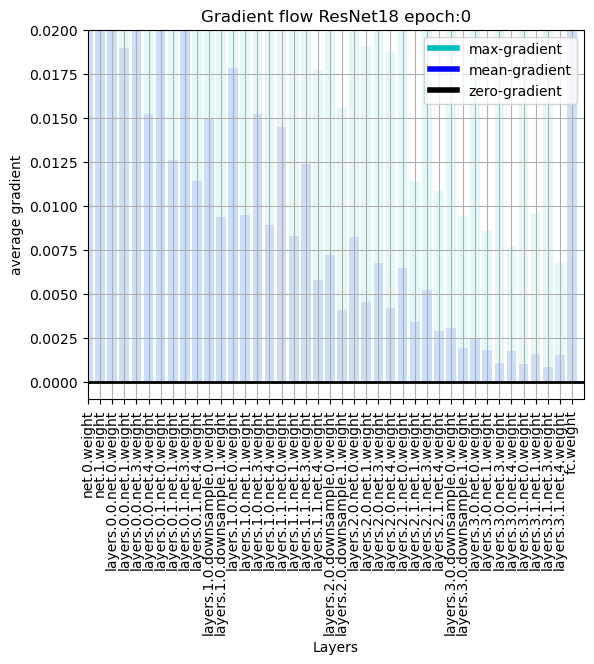

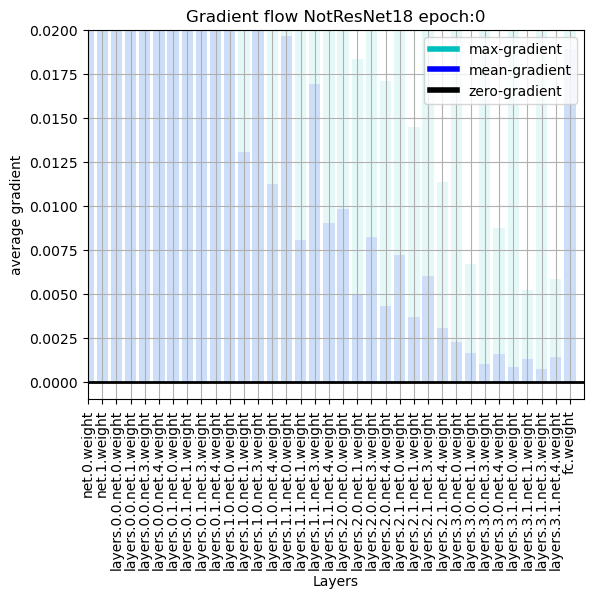

Training epoch 0: 100%|██████████| 391/391 [02:28<00:00,  2.63it/s]


Epoch 0: Loss ResNet: 2.3055, Loss Not ResNet: 2.1700


Training epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

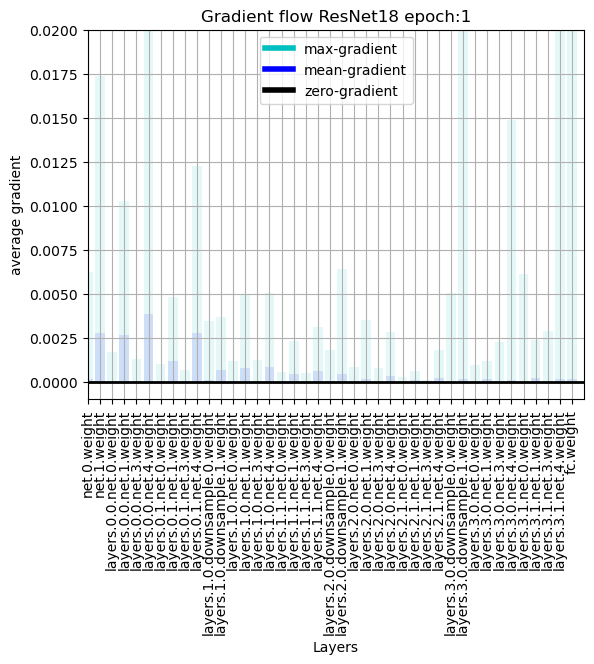

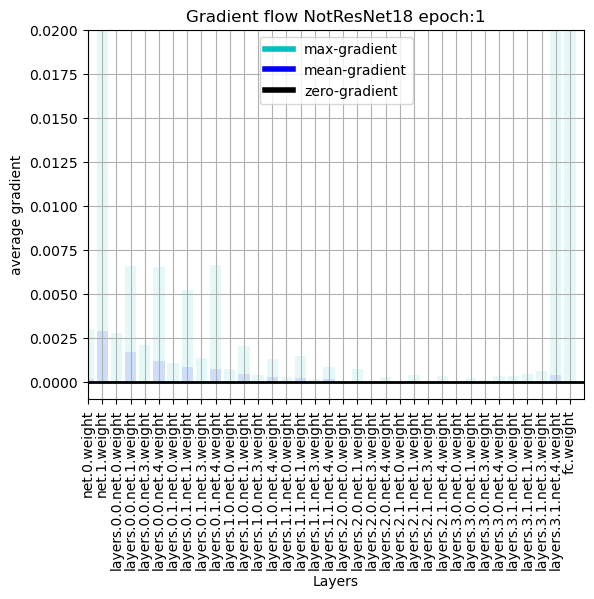

Training epoch 1: 100%|██████████| 391/391 [02:29<00:00,  2.61it/s]


Epoch 1: Loss ResNet: 1.7185, Loss Not ResNet: 1.8707


Training epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

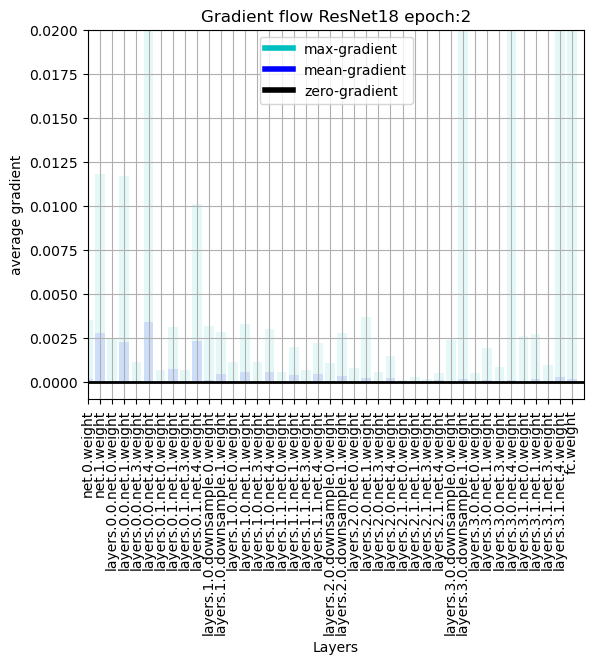

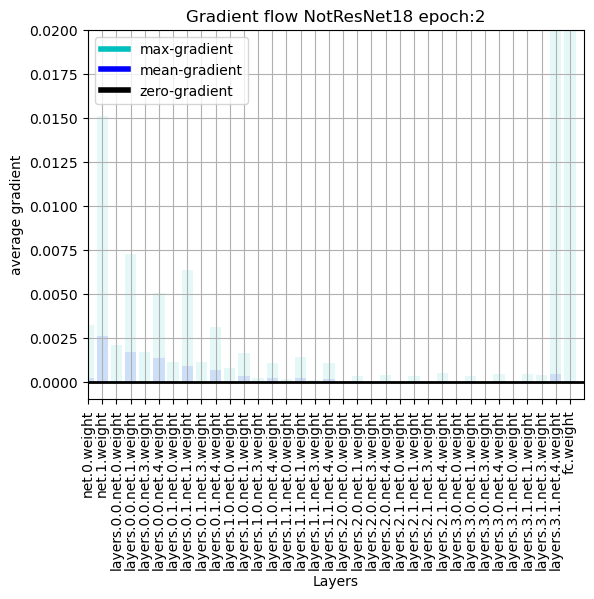

Training epoch 2: 100%|██████████| 391/391 [02:28<00:00,  2.63it/s]


Epoch 2: Loss ResNet: 1.6138, Loss Not ResNet: 1.8389


Training epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

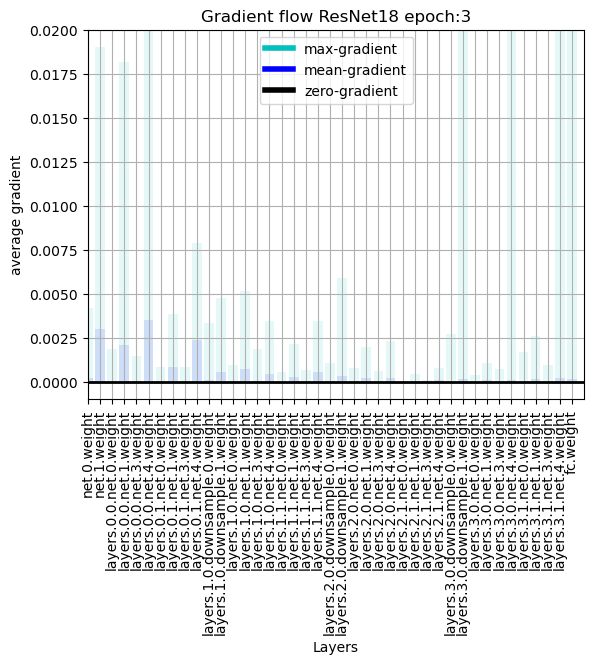

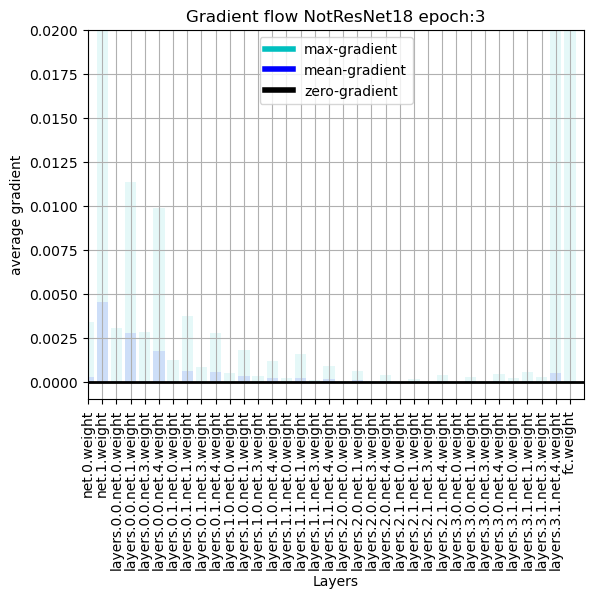

Training epoch 3: 100%|██████████| 391/391 [02:26<00:00,  2.66it/s]


Epoch 3: Loss ResNet: 1.4267, Loss Not ResNet: 1.8154


Training epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

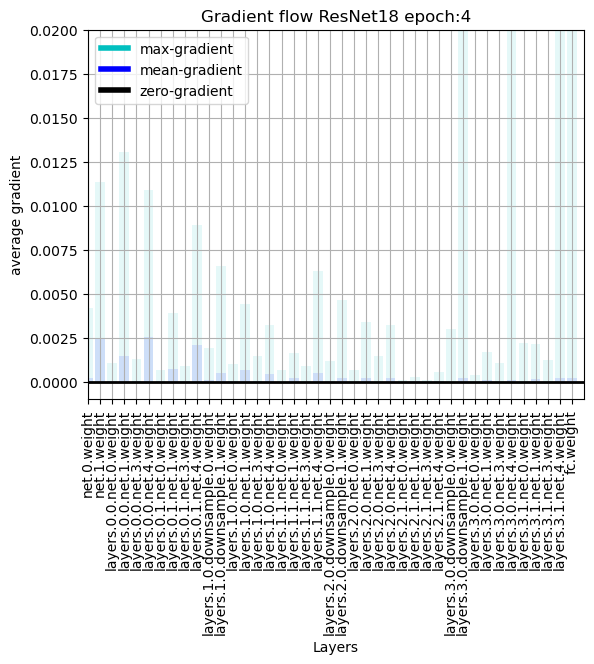

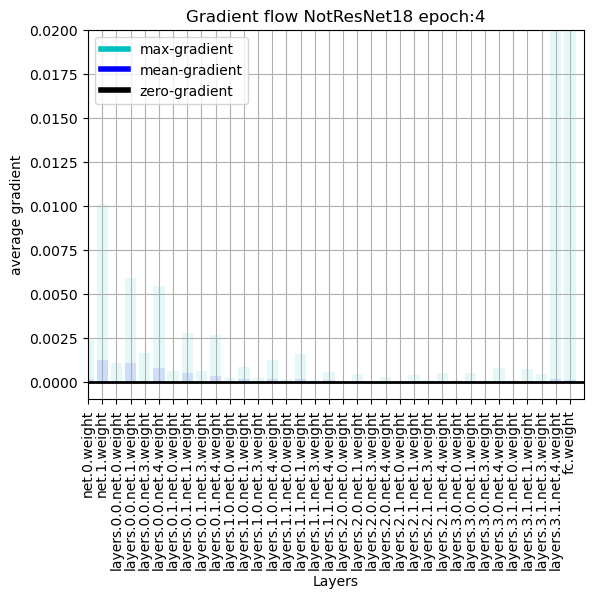

Training epoch 4: 100%|██████████| 391/391 [02:27<00:00,  2.66it/s]


Epoch 4: Loss ResNet: 1.2748, Loss Not ResNet: 1.6129


Training epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

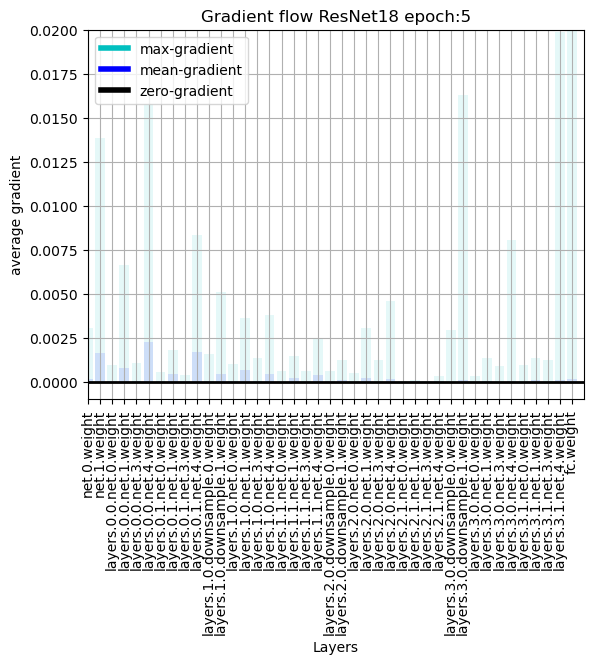

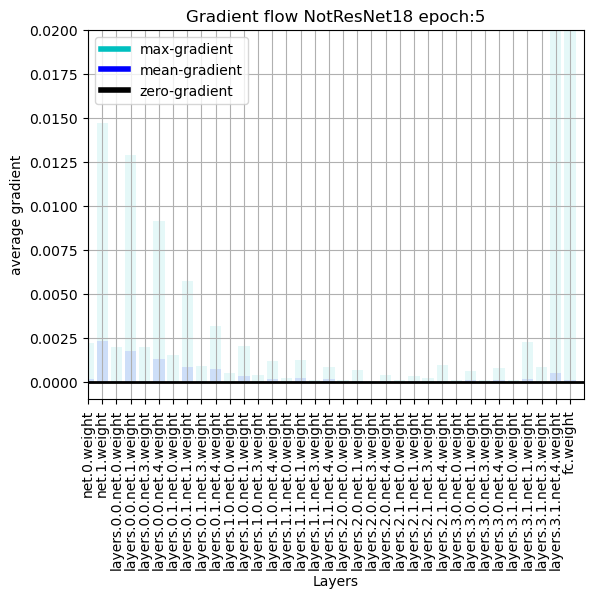

Training epoch 5: 100%|██████████| 391/391 [02:29<00:00,  2.62it/s]


Epoch 5: Loss ResNet: 1.1514, Loss Not ResNet: 1.4617


Training epoch 6:   0%|          | 0/391 [00:00<?, ?it/s]

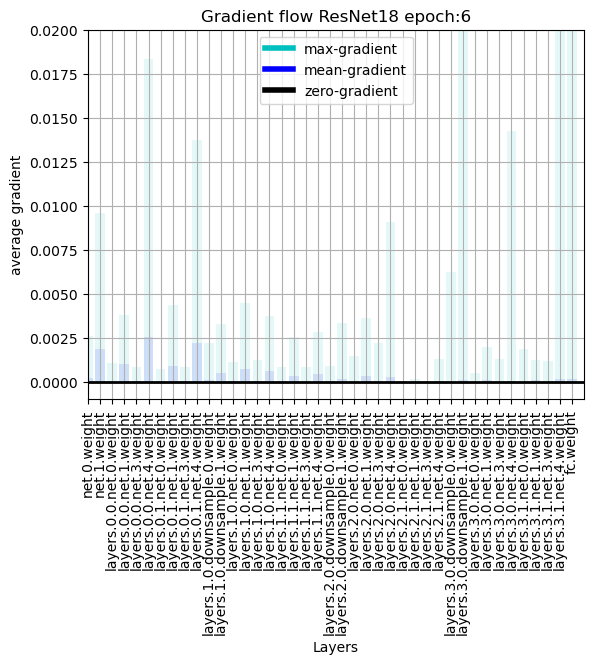

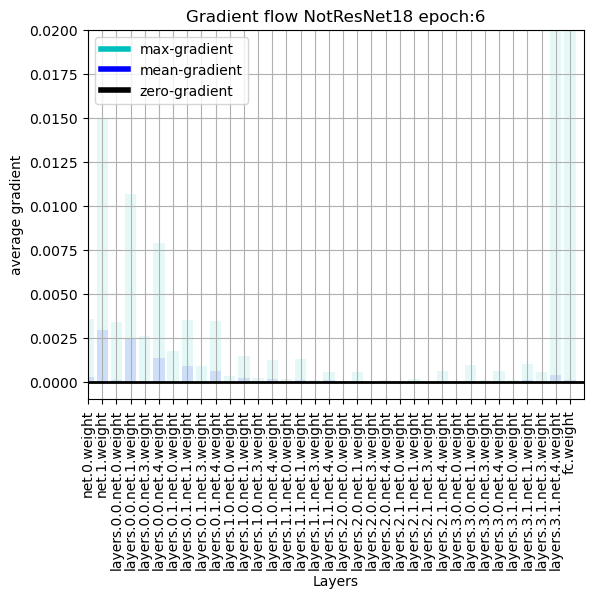

Training epoch 6: 100%|██████████| 391/391 [02:29<00:00,  2.62it/s]


Epoch 6: Loss ResNet: 1.0515, Loss Not ResNet: 1.3728


Training epoch 7:   0%|          | 0/391 [00:00<?, ?it/s]

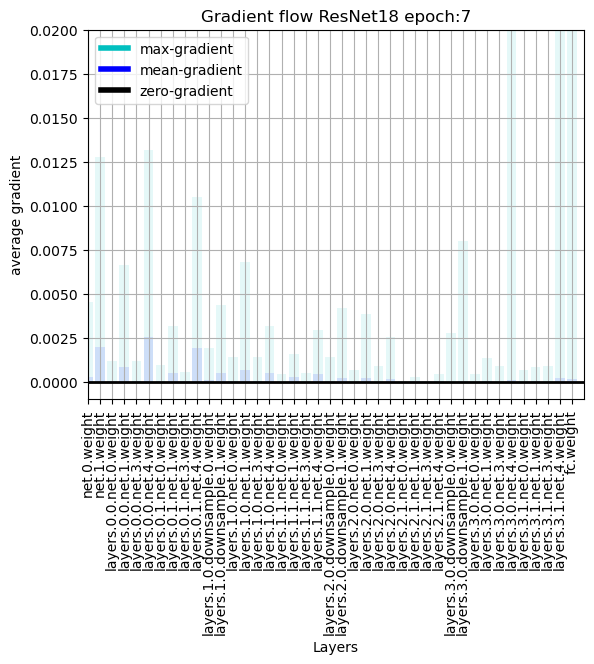

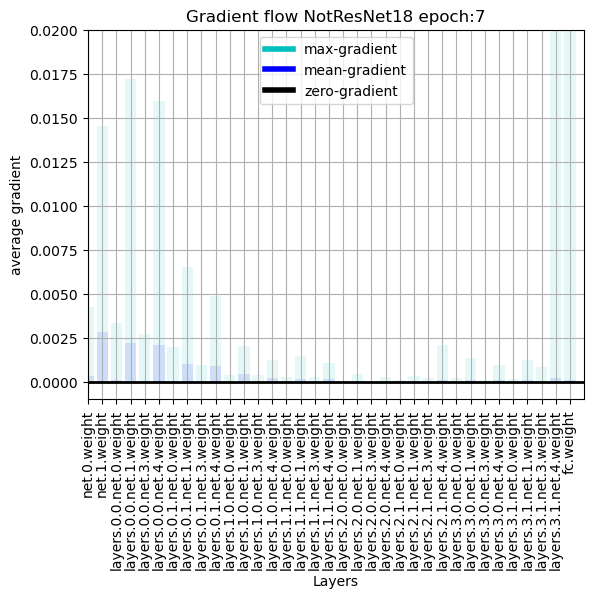

Training epoch 7: 100%|██████████| 391/391 [02:28<00:00,  2.63it/s]


Epoch 7: Loss ResNet: 0.9752, Loss Not ResNet: 1.3122


Training epoch 8:   0%|          | 0/391 [00:00<?, ?it/s]

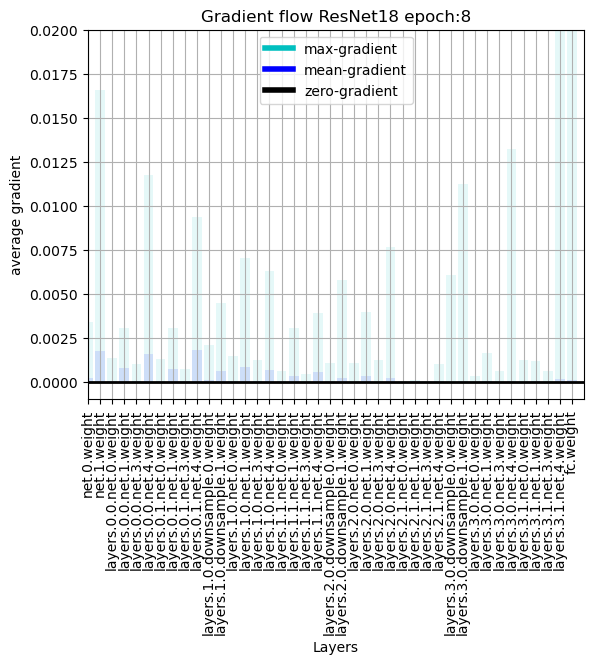

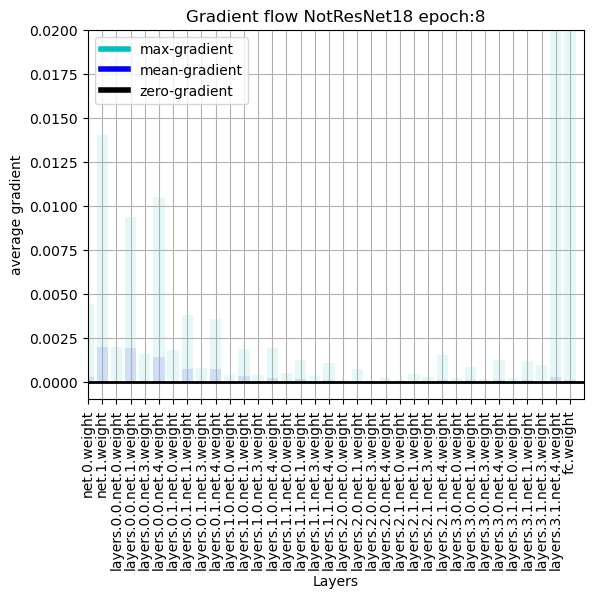

Training epoch 8: 100%|██████████| 391/391 [02:28<00:00,  2.64it/s]


Epoch 8: Loss ResNet: 0.8986, Loss Not ResNet: 1.2593


Training epoch 9:   0%|          | 0/391 [00:00<?, ?it/s]

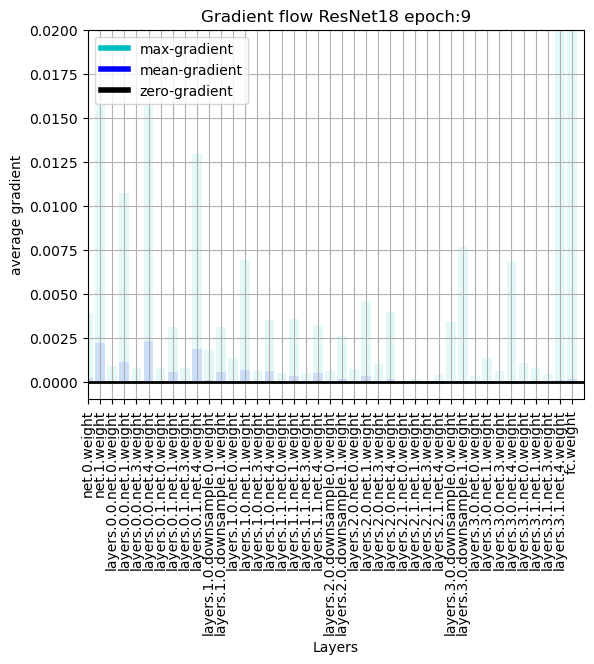

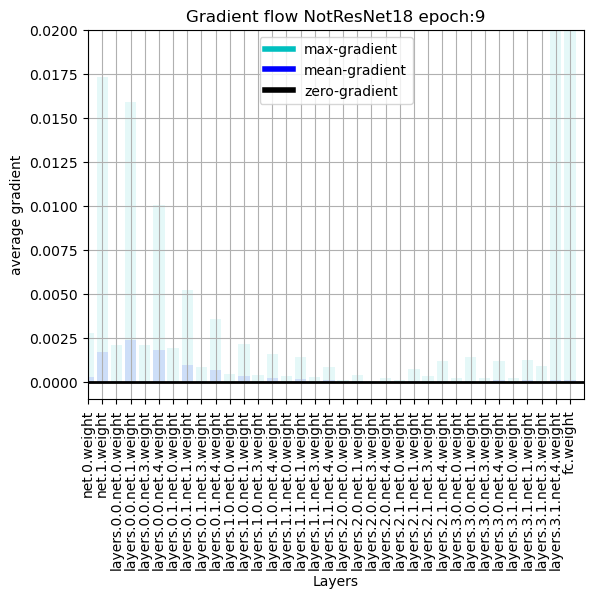

Training epoch 9: 100%|██████████| 391/391 [02:26<00:00,  2.67it/s]


Epoch 9: Loss ResNet: 0.8472, Loss Not ResNet: 1.2148


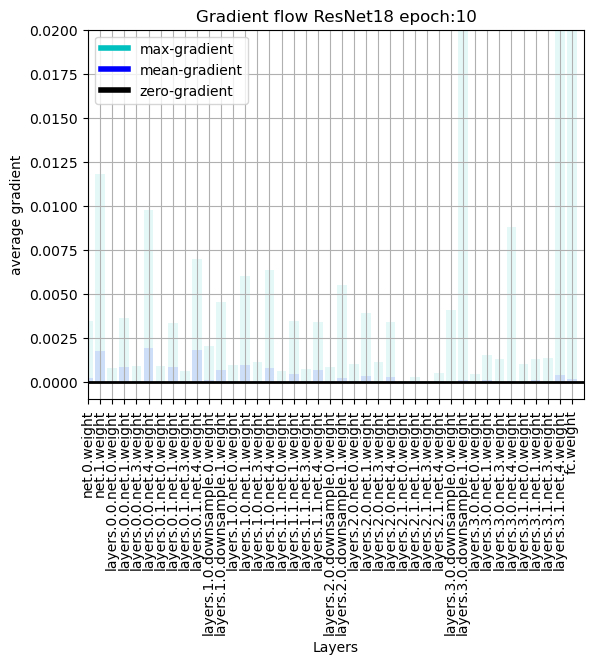

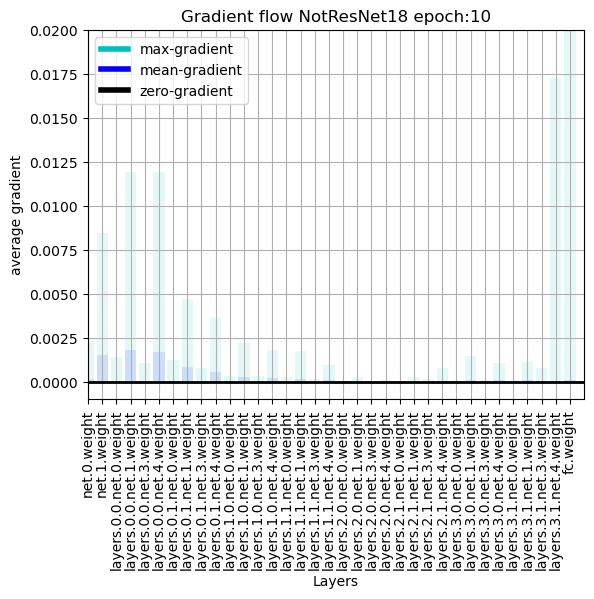

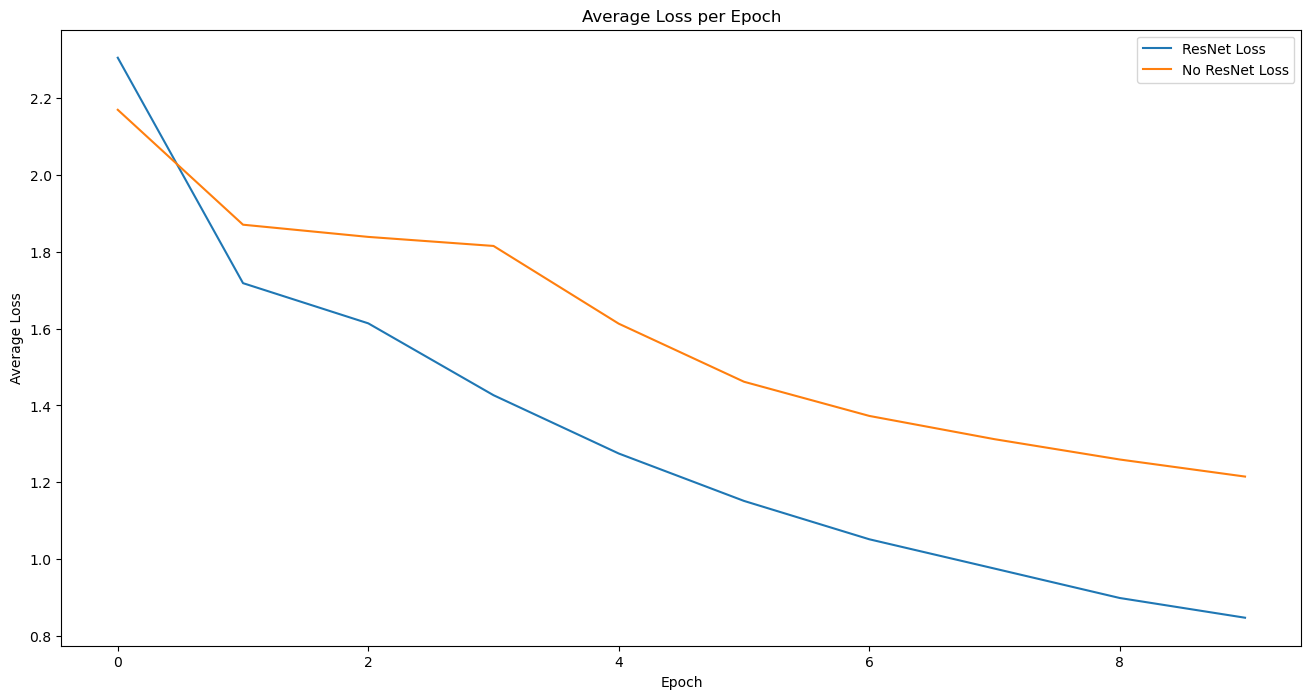

In [50]:
# Retrain the ResNet18 model and the CNN model for quantify the gradient vanishing problem
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_resnet18 = resnet18().to(device)
model_notresnet18 = resnet18_no_skip().to(device)

# Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

ds_train = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
ds_test = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

batch_size = 128

dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=False)
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=False)

# Loss and optimizer
lr = 0.1
opt_resnet = torch.optim.Adam(model_resnet18.parameters(), lr=lr)
opt_notres = torch.optim.Adam(model_notresnet18.parameters(), lr=lr)

def train_gradient(model_res, model_not, opt_res, opt_not, epochs):
    model_res.train()
    model_not.train()

    losses_res = []
    losses_not = []
    for epoch in range(epochs):
        ls_res = []
        ls_not = []
        for (i, (xs, ys)) in enumerate(tqdm(dl_train, desc=f'Training epoch {epoch}', leave=True)):
            xs, ys = xs.to(device), ys.to(device)
            
            opt_res.zero_grad()
            opt_not.zero_grad()

            outputs_res = model_res(xs)
            outputs_not = model_not(xs)

            loss_res = F.cross_entropy(outputs_res, ys)
            loss_not = F.cross_entropy(outputs_not, ys)
            
            loss_res.backward()
            loss_not.backward()

            opt_res.step()
            opt_not.step()

            ls_res.append(loss_res.item())
            ls_not.append(loss_not.item())
            if i == 0:
                plot_grad_flow(model_res.named_parameters(), "ResNet18 epoch:"+str(epoch))
                plot_grad_flow(model_not.named_parameters(), "NotResNet18 epoch:"+str(epoch))
        ls_res = np.mean(ls_res)
        ls_not = np.mean(ls_not)

        losses_res.append(ls_res)
        losses_not.append(ls_not)
        print(f"Epoch {epoch}: Loss ResNet: {ls_res:.4f}, Loss Not ResNet: {ls_not:.4f}")

    plot_grad_flow(model_res.named_parameters(), "ResNet18 epoch:"+str(epoch+1))
    plot_grad_flow(model_not.named_parameters(), "NotResNet18 epoch:"+str(epoch+1))
    return losses_res, losses_not

epochs = 10

resnet_loss, notres_loss = train_gradient(model_resnet18, model_notresnet18, opt_resnet, opt_notres, epochs)
plot_train_loss(resnet_loss, notres_loss)

----
# Exercise 2.2: Fully-convolutionalize a network.
Take one of your trained classifiers and **fully-convolutionalize** it. That is, turn it into a network that can predict classification outputs at *all* pixels in an input image. Can you turn this into a **detector** of handwritten digits? Give it a try.

**Hint 1**: Sometimes the process of fully-convolutionalization is called "network surgery".

**Hint 2**: To test your fully-convolutionalized networks you might want to write some functions to take random MNIST samples and embed them into a larger image (i.e. in a regular grid or at random positions).

In [65]:
# TRAINING AND EVALUATION FUNCTIONS 
# Function to train one epoch
def train_epoch(
        model: nn.Module, 
        data: DataLoader, 
        epoch: int, 
        opt: optim.Optimizer, 
        device="cuda"
    ):

    model.train()

    losses = []
    gts = []
    preds = []

    # Zero out the gradients
    opt.zero_grad()
    
    for (i, (xs, ys)) in enumerate(tqdm(data, desc=f"Training epoch {epoch}", leave=True)):
        # Get the input and target data and move it to the device
        xs= xs.to(device)
        ys = binarize_mnist_tensor(xs, ys).to(device)

        # Zero out the gradients
        opt.zero_grad()

        # Forward pass
        logits = model(xs)

        # Get the predicted classes
        pred = torch.argmax(logits, 1)
        
        # Compute the cross entropy loss
        loss = F.cross_entropy(logits, ys)

        # Backward pass
        loss.backward()

        # Update the model parameters
        opt.step()

        # Append the loss
        losses.append(loss.item())
        preds.extend(pred.flatten().detach().cpu().numpy())
        gts.extend(ys.flatten().detach().cpu().numpy())

    # Compute the accuracy and classification report
    accuracy = accuracy_score(gts, preds)

    # Log the results
    loss = np.mean(losses)
    wandb.log({
        "train/epoch": epoch, 
        "train/loss": loss, 
        "train/accuracy": accuracy, 
        },
        step=epoch)

    # Return the average loss, accuracy and classification report
    return loss, accuracy

# Function to evaluate one epoch
def evaluate_epoch(
        model: nn.Module, 
        data: DataLoader, 
        epoch: int, 
        device="cuda"
    ):

    model.eval()

    losses = []
    preds = []
    gts = []
    # Disable gradient computation for evaluation
    with torch.no_grad():
        for (_, (xs, ys)) in enumerate(tqdm(data, desc=f"Evaluating", leave=True)):
            # Get the input and target data and move it to the device
            xs = xs.to(device)
            ys = binarize_mnist_tensor(xs, ys).to(device)

            # Forward pass
            logits = model(xs)

            # Compute the cross entropy loss
            loss = F.cross_entropy(logits, ys)

            # Get the predicted classes
            pred = torch.argmax(logits, 1)

            # Append the loss, predictions and ground truths
            losses.append(loss.item())
            preds.extend(pred.flatten().detach().cpu().numpy())
            gts.extend(ys.flatten().detach().cpu().numpy())

    # Compute the accuracy and classification report
    accuracy = accuracy_score(gts, preds)

    # Log the results
    loss = np.mean(losses)
    wandb.log({
        "val/epoch": epoch, 
        "val/loss": loss, 
        "val/accuracy": accuracy,     
        }, 
        step=epoch)
    
    return loss, accuracy

# Function to train and evaluate the model
def train_evaluate_model(
        model: nn.Module, 
        model_name: str,
        dataset_name: str,
        dl_train: DataLoader, 
        dl_test: DataLoader, 
        batch_size: int, 
        lr: int, 
        epochs: int, 
        opt: optim.Optimizer, 
        device="cuda",
    ):

    time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    test_name = model_name+"-"+time+"_"+dataset_name+"_epochs-"+str(epochs)+"_bs-"+str(batch_size)+"_lr-"+str(lr)

    wandb_init(model_name, test_name, model, dataset_name, epochs, batch_size, lr, device)

    # Train and evaluate the model
    train_results = {"loss": [], "acc": []}
    val_results = {"loss": [], "acc": []}
    max_val_acc = 0
    state_dict = None

    for epoch in range(epochs):
        # Train the model 
        train_loss, train_acc = train_epoch(model, dl_train, epoch, opt, device=device)

        # Evaluate the model
        val_loss, val_acc = evaluate_epoch(model, dl_test, epoch, device=device)

        print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save the best model
        if val_acc > max_val_acc:
            max_val_acc = val_acc
            state_dict = model.state_dict()
        
        # Append the results
        train_results["loss"].append(train_loss)
        train_results["acc"].append(train_acc)
        val_results["loss"].append(val_loss)
        val_results["acc"].append(val_acc)

    wandb.unwatch(model)
    wandb.finish()

    plot_validation_curves(train_results["loss"], val_results["loss"], train_results["acc"], val_results["acc"])

    model_states_path = "model_states/"+test_name+".pth"

    # Save the best model
    if state_dict is not None:
        torch.save(state_dict, model_states_path)
        print(f"Model saved to {model_states_path}")

# Function to initialize wandb
def wandb_init(
        model_name, 
        test_name, 
        model, 
        dataset, 
        epochs, 
        bs, 
        lr, 
        device, 
        project="DLA Assigment 1"
    ):
    # Initialize wandb
    wandb.init(
        project=project,
        name=test_name,
        # Track hyperparameters and run metadata
        config={
            "architecture": model_name,
            "dataset": dataset,
            "epochs": epochs,
            "batch_size": bs,
            "lr": lr,
            "optimizer": "Adam",
            "device": device.type
        }
    )
    wandb.watch(model, nn.CrossEntropyLoss(), log="all")

# Simple function to plot the loss curve and accuracy.
def plot_validation_curves(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.title('Average Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='train_acc')
    plt.plot(val_acc, label='val_acc')
    plt.title(f'Best Validation Accuracy = {np.max(val_acc)} @ epoch {np.argmax(val_acc)}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

In [66]:
class ResNet18FCN(nn.Module):
    def __init__(self, model):
        super(ResNet18FCN, self).__init__()
        self.num_classes = model.num_classes

        # Remove the fully connected layer
        self.model = nn.Sequential(*list(model.children())[:-1])

        # Fully convolutional classification layer
        self.classifier = nn.Conv2d(512, self.num_classes, kernel_size=1)

        # Upsample the output to the input size
        self.resizer = nn.ConvTranspose2d(self.num_classes, self.num_classes, kernel_size=64, padding=16, stride=32)

    def forward(self, x):
        out = self.model(x)                              # [batch_size, 512, 1, 1]
        out = self.classifier(out)                       # [batch_size, 512, 1, 1] -> [batch_size, num_classes, 1, 1]
        out = self.resizer(out)                          # [batch_size, num_classes, 1, 1] -> [batch_size, num_classes, 32, 32]
        return out

In [67]:
# For every batch change the xs tensor to ys where xs pixel > 0.5
def binarize_mnist_tensor(xs, ys):
    xss = xs.clone()
    for i in range(xss.size(0)):
        image = xss[i]
        image = image.squeeze()
        black = image > 0.5
        image[black] = ys[i]
        image[~black] = 10
    return xss.squeeze().long()

Evaluating: 100%|██████████| 157/157 [00:08<00:00, 18.27it/s]


Epoch 0: Train Loss: 0.2472, Train Acc: 0.9040, Val Loss: 0.1741, Val Acc: 0.9271


Evaluating: 100%|██████████| 157/157 [00:08<00:00, 18.54it/s]


Epoch 1: Train Loss: 0.1590, Train Acc: 0.9332, Val Loss: 0.1433, Val Acc: 0.9400


Evaluating: 100%|██████████| 157/157 [00:08<00:00, 19.22it/s]


Epoch 2: Train Loss: 0.1407, Train Acc: 0.9409, Val Loss: 0.1330, Val Acc: 0.9446


Evaluating: 100%|██████████| 157/157 [00:08<00:00, 18.77it/s]


Epoch 3: Train Loss: 0.1335, Train Acc: 0.9438, Val Loss: 0.1265, Val Acc: 0.9469


Evaluating: 100%|██████████| 157/157 [00:08<00:00, 19.46it/s]


Epoch 4: Train Loss: 0.1281, Train Acc: 0.9460, Val Loss: 0.1235, Val Acc: 0.9484


Evaluating: 100%|██████████| 157/157 [00:08<00:00, 18.32it/s]


Epoch 5: Train Loss: 0.1244, Train Acc: 0.9474, Val Loss: 0.1181, Val Acc: 0.9505


Evaluating: 100%|██████████| 157/157 [00:08<00:00, 19.28it/s]


Epoch 6: Train Loss: 0.1224, Train Acc: 0.9484, Val Loss: 0.1200, Val Acc: 0.9497


Evaluating: 100%|██████████| 157/157 [00:08<00:00, 19.61it/s]


Epoch 7: Train Loss: 0.1193, Train Acc: 0.9495, Val Loss: 0.1192, Val Acc: 0.9506


Evaluating: 100%|██████████| 157/157 [00:08<00:00, 17.72it/s]


Epoch 8: Train Loss: 0.1170, Train Acc: 0.9503, Val Loss: 0.1122, Val Acc: 0.9529


Evaluating: 100%|██████████| 157/157 [00:08<00:00, 18.95it/s]


Epoch 9: Train Loss: 0.1151, Train Acc: 0.9512, Val Loss: 0.1153, Val Acc: 0.9524


train/accuracy,▁▅▆▇▇▇████
train/epoch,▁▂▃▃▄▅▆▆▇█
train/loss,█▃▂▂▂▁▁▁▁▁
val/accuracy,▁▅▆▆▇▇▇▇██
val/epoch,▁▂▃▃▄▅▆▆▇█
val/loss,█▅▃▃▂▂▂▂▁▁
train/accuracy,0.95122
train/epoch,9
train/loss,0.11509
val/accuracy,0.95241
val/epoch,9


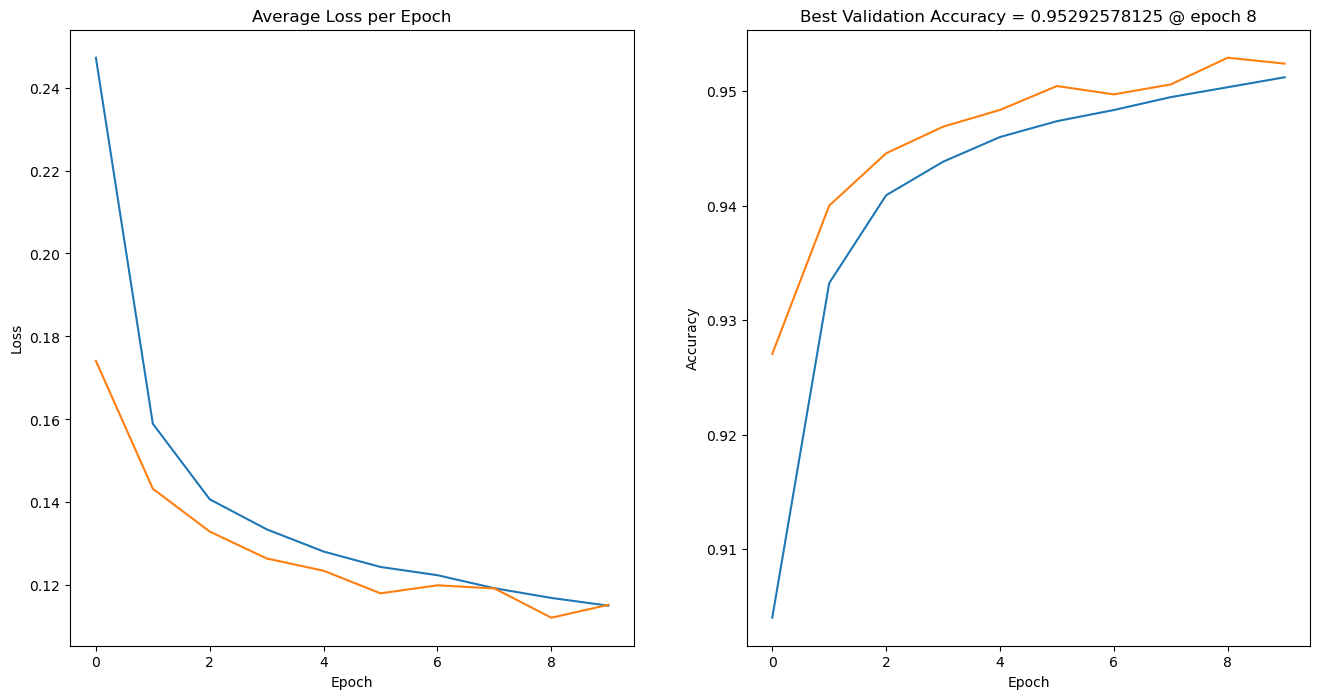

Model saved to model_states/ResNet18FCN-2024-07-19_18-02-46_MNIST_32x32_epochs-10_bs-64_lr-0.01.pth


In [71]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 64

# Transform
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Dataset
ds_train = MNIST(root='../data', train=True, download=True, transform=transform)
ds_test = MNIST(root='../data', train=False, download=True, transform=transform)

# Dataloader
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=False)

# Create the fully convolutional model
resnet18_fcn = ResNet18FCN(resnet18(channels=1, num_classes=11)).to(device)

# Loss and optimizer
epochs = 10
lr = 0.01
opt = torch.optim.Adam(resnet18_fcn.parameters(), lr=lr)

# Train and evaluate the model
train_evaluate_model(
    resnet18_fcn, 
    "ResNet18FCN", 
    "MNIST_32x32", 
    dl_train, 
    dl_test, 
    batch_size, 
    lr, 
    epochs, 
    opt, 
    device=device
)

In [72]:
# PLOT THE RESULTS
def plot_results_image(xs, ys):
    fig, axs = plt.subplots(1, 3, figsize=(20, 15))
    # Plot the input image
    axs[0].imshow(xs, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title('Input Image')

    # Plot the output image
    axs[1].imshow(ys, cmap='tab10')
    axs[1].axis('off')
    axs[1].set_title('Output Image')

    # Plot the class prediction for each pixel
    axs[2].imshow(xs, cmap='gray')
    axs[2].axis('off')
    axs[2].set_title('Class Prediction')
    img = []
    for i in range(ys.shape[0]):
        row = []
        for j in range(ys.shape[1]):
            row.append(i+j)
            if int(ys[i, j]) < 10:
                axs[2].text(j, i, int(ys[i, j]), ha='center', va='center', color='black')
            else:
                axs[2].text(j, i, '*', ha='center', va='center', color='black')
        img.append(row)
    axs[2].imshow(img, alpha=0.5)
    plt.show()

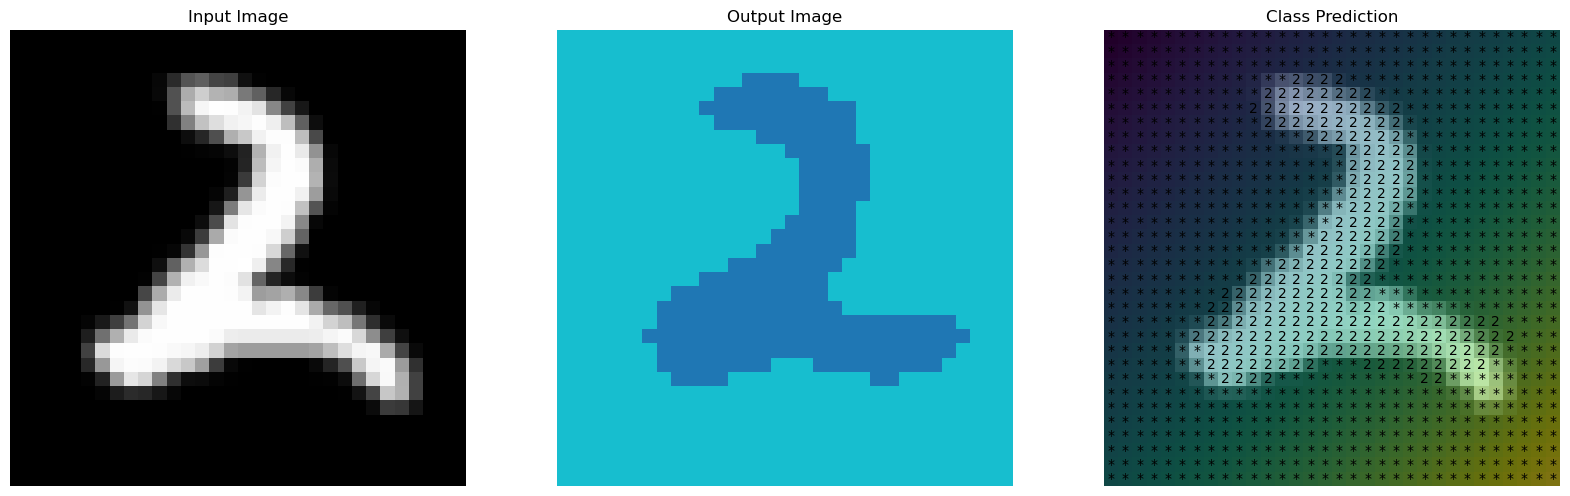

In [88]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the model from the saved state
model = ResNet18FCN(resnet18(channels=1, num_classes=11)).to(device)
model.eval()

model_states_path = "model_states/ResNet18FCN-2024-07-19_18-02-46_MNIST_32x32_epochs-10_bs-64_lr-0.01.pth"

model.load_state_dict(torch.load(model_states_path))

# Transform
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Dataset
ds_test = MNIST(root='../data', train=False, download=True, transform=transform)

# Get one random image from the test set
idx = np.random.randint(0, len(ds_test))
xs, ys = ds_test[idx]

# predict the output
pred = torch.argmax(model(xs.unsqueeze(0).to(device)), 1)

# Plot the results
plot_results_image(xs.squeeze(), pred.squeeze().cpu().numpy())

----
# Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.2 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes.

**Note**: Feel free to implement [Grad-CAM](https://arxiv.org/abs/1610.02391) instead of CAM.

In [90]:
# TRAINING AND EVALUATION FUNCTIONS 
# Function to train one epoch
def train_epoch(
        model: nn.Module, 
        data: DataLoader, 
        class_names: list, 
        epoch: int, 
        opt: optim.Optimizer, 
        device="cuda"
    ):

    model.train()

    losses = []
    gts = []
    preds = []

    # Zero out the gradients
    opt.zero_grad()
    
    for (i, (xs, ys)) in enumerate(tqdm(data, desc=f"Training epoch {epoch}", leave=True)):
        # Get the input and target data and move it to the device
        xs, ys = xs.to(device), ys.to(device)

        # Zero out the gradients
        opt.zero_grad()

        # Forward pass
        logits = model(xs)

        # Get the predicted classes
        pred = torch.argmax(logits, 1)
        
        # Compute the cross entropy loss
        loss = F.cross_entropy(logits, ys)

        # Backward pass
        loss.backward()

        # Update the model parameters
        opt.step()

        # Append the loss
        losses.append(loss.item())
        preds.extend(pred.detach().cpu().numpy())
        gts.extend(ys.detach().cpu().numpy())

    # Compute the accuracy and classification report
    accuracy = accuracy_score(gts, preds)
    class_report = classification_report(gts, preds, zero_division=0, digits=3, output_dict=True)
    class_report_db = classification_report(gts, preds, zero_division=0, digits=3).splitlines()

    report_table = []
    for line in class_report_db[2:(len(class_names)+2)]:
       report_table.append(line.split())

    # Log the results
    loss = np.mean(losses)
    wandb.log({
        "train/epoch": epoch, 
        "train/loss": loss, 
        "train/accuracy": accuracy, 
        "train_class_rep/classification_report": class_report,
        "train/confusion_matrix": wandb.plot.confusion_matrix(y_true=gts, preds=preds, class_names=class_names),
        "train/classification_report": wandb.Table(data=report_table, columns=["Class", "Precision", "Recall", "F1-score", "Support"])
        },
        step=epoch)

    # Return the average loss, accuracy and classification report
    return loss, accuracy, class_report

# Function to evaluate one epoch
def evaluate_epoch(
        model: nn.Module, 
        data: DataLoader, 
        class_names: list, 
        epoch: int, 
        device="cuda"
    ):

    model.eval()

    losses = []
    preds = []
    gts = []
    # Disable gradient computation for evaluation
    with torch.no_grad():
        for (_, (xs, ys)) in enumerate(tqdm(data, desc=f"Evaluating", leave=True)):
            # Get the input and target data and move it to the device
            xs, ys = xs.to(device), ys.to(device)

            # Forward pass
            logits = model(xs)

            # Compute the cross entropy loss
            loss = F.cross_entropy(logits, ys)

            # Get the predicted classes
            pred = torch.argmax(logits, 1)

            # Append the loss, predictions and ground truths
            losses.append(loss.item())
            preds.extend(pred.detach().cpu().numpy())
            gts.extend(ys.detach().cpu().numpy())

    # Compute the accuracy and classification report
    accuracy = accuracy_score(gts, preds)
    class_report = classification_report(gts, preds, zero_division=0, digits=3, output_dict=True)

    class_report_db = classification_report(gts, preds, zero_division=0, digits=3).splitlines()
    report_table = []
    for line in class_report_db[2:(len(class_names)+2)]:
        report_table.append(line.split())

    # Log the results
    loss = np.mean(losses)
    wandb.log({
        "val/epoch": epoch, 
        "val/loss": loss, 
        "val/accuracy": accuracy,
        "val_class_rep/classification_report": class_report,
        "val/confusion_matrix": wandb.plot.confusion_matrix(y_true=gts, preds=preds, class_names=class_names),
        "val/classification_report": wandb.Table(data=report_table, columns=["Class", "Precision", "Recall", "F1-score", "Support"])
        }, 
        step=epoch)
    
    return loss, accuracy, class_report

# Function to train and evaluate the model
def train_evaluate_model(
        model: nn.Module, 
        model_name: str,
        dataset_name: str,
        class_names: list,
        dl_train: DataLoader, 
        dl_test: DataLoader, 
        batch_size: int, 
        lr: int, 
        epochs: int, 
        opt: optim.Optimizer, 
        device="cuda",
    ):

    time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    test_name = model_name+"-"+time+"_"+dataset_name+"_epochs-"+str(epochs)+"_bs-"+str(batch_size)+"_lr-"+str(lr)

    wandb_init(model_name, test_name, model, dataset_name, epochs, batch_size, lr, device)

    # Train and evaluate the model
    train_results = {"loss": [], "acc": [], "class_rep": []}
    val_results = {"loss": [], "acc": [], "class_rep": []}
    max_val_acc = 0
    state_dict = None

    for epoch in range(epochs):
        # Train the model 
        train_loss, train_acc, train_class_rep = train_epoch(model, dl_train, class_names, epoch, opt, device=device)

        # Evaluate the model
        val_loss, val_acc, val_class_rep = evaluate_epoch(model, dl_test, class_names, epoch, device=device)

        print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save the best model
        if val_acc > max_val_acc:
            max_val_acc = val_acc
            state_dict = model.state_dict()
        
        # Append the results
        train_results["loss"].append(train_loss)
        train_results["acc"].append(train_acc)
        train_results["class_rep"].append(train_class_rep)
        val_results["loss"].append(val_loss)
        val_results["acc"].append(val_acc)
        val_results["class_rep"].append(val_class_rep)

    wandb.unwatch(model)
    wandb.finish()

    plot_validation_curves(train_results["loss"], val_results["loss"], train_results["acc"], val_results["acc"])

    model_states_path = "model_states/"+test_name+".pth"

    # Save the best model
    if state_dict is not None:
        torch.save(state_dict, model_states_path)
        print(f"Model saved to {model_states_path}")

# Function to initialize wandb
def wandb_init(
        model_name, 
        test_name, 
        model, 
        dataset, 
        epochs, 
        bs, 
        lr, 
        device, 
        project="DLA Assigment 1"
    ):
    # Initialize wandb
    wandb.init(
        project=project,
        name=test_name,
        # Track hyperparameters and run metadata
        config={
            "architecture": model_name,
            "dataset": dataset,
            "epochs": epochs,
            "batch_size": bs,
            "lr": lr,
            "optimizer": "Adam",
            "device": device.type
        }
    )
    wandb.watch(model, nn.CrossEntropyLoss(), log="all")

# Simple function to plot the loss curve and accuracy.
def plot_validation_curves(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.title('Average Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='train_acc')
    plt.plot(val_acc, label='val_acc')
    plt.title(f'Best Validation Accuracy = {np.max(val_acc)} @ epoch {np.argmax(val_acc)}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

In [91]:
"""
TRAINING THE RESIDUAL CNN MODEL ON CIFAR10
"""
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
batch_size = 128
epochs = 20
lr = 0.01

# Load CIFAR10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

ds_train = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
ds_val = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size, shuffle=True)

# Initialize the CNN model
model = resnet18(num_classes=10).to(device)

# Define loss function and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Train and evaluate the model
train_evaluate_model(
    model=model, 
    model_name="ResNet18", 
    dataset_name="CIFAR10", 
    class_names=ds_train.classes, 
    dl_train=dl_train, 
    dl_test=dl_val, 
    batch_size=batch_size, 
    lr=lr, 
    epochs=epochs, 
    opt=optimizer, 
    device=device
)

Files already downloaded and verified
Files already downloaded and verified


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 17.95it/s]


Epoch 0: Train Loss: 1.7549, Train Acc: 0.3809, Val Loss: 1.3884, Val Acc: 0.4943


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 17.83it/s]


Epoch 1: Train Loss: 1.2283, Train Acc: 0.5623, Val Loss: 1.2025, Val Acc: 0.5773


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 17.21it/s]


In [282]:
# The GradCamModel class is a wrapper around the model that allows us to get the gradients of the activations of the last layer.
class GradCamModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

        self.gradients = None
        self.activations = None

        self.layerhook = []
        self.register_hooks()

    def register_hooks(self):
        pre_activation_layer = self.model.layer4[-1]
        # print(pre_activation_layer)

        # Forward hook to capture the activations of the last layer
        self.layerhook.append(pre_activation_layer.register_forward_hook(self.forward_hook(), prepend=False))
        
        # Backward hook to capture the gradients of the activations
        self.layerhook.append(pre_activation_layer.register_full_backward_hook(self.backward_hook(), prepend=False))

    def forward_hook(self):
        print("forward_hook")
        def hook(module, input, output):
            print(f'Activations size: {output.size()}')
            self.activations = output
        return hook

    def backward_hook(self):
        print("backward_hook")
        def hook(module, grad_input, grad_output):
            print(f'Gradients size: {grad_output[0].size()}')
            self.gradients = grad_output
        return hook

    def forward(self, x):
        out = self.model(x)
        return out

    def get_activations(self):
        return self.activations

    def get_gradients(self):
        return self.gradients

    def remove_hooks(self):
        for hook in self.layerhook:
            hook.remove()

In [312]:
def get_heatmap(model, image, label):
    logits = model(image)
    loss = F.cross_entropy(logits, label)
    loss.backward()

    grads = model.get_gradients()[0]

    # pool the gradients across the channels
    pooled_gradients = torch.mean(grads, dim=[0, 2, 3])

    # get the activations of the last layer
    activations = model.get_activations()

    # weight the channels by corresponding gradients
    for i in range(activations.size()[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()

    heatmap = F.relu(heatmap)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    return heatmap.detach()

In [315]:
def plot_heatmap(image, heatmap):
    # Plot the original image, heatmap and overlayed image
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title('Original Image')
    plt.axis('off')

    # Resize heatmap to the original image size
    zoom_factor = (image.shape[1] / heatmap.shape[0], image.shape[2] / heatmap.shape[1])
    heatmap = zoom(heatmap.numpy(), zoom_factor)
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title('Heatmap')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(image.permute(1, 2, 0))
    plt.imshow(heatmap, alpha=0.5)
    plt.title('Overlayed Image')
    plt.axis('off')

    plt.show()

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


forward_hook
backward_hook
Activations size: torch.Size([1, 512, 4, 4])
Gradients size: torch.Size([1, 512, 4, 4])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


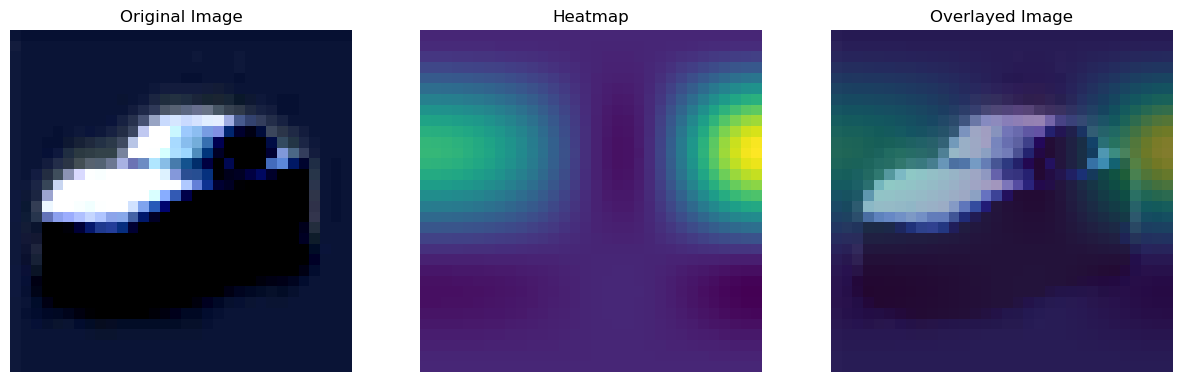

In [321]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# Load the pre-trained ResNet18 model
resnet18_path = 'model_states/ResNet18-2024-07-03_18-38-31_CIFAR10_epochs-20_bs-128_lr-0.1.pth'
model_resnet18 = ResNet([2, 2, 2, 2], 10)

model_resnet18.load_state_dict(torch.load(resnet18_path))
model_resnet18.to(device)
model_resnet18.eval()

# Load CIFAR10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

gradcam_model = GradCamModel(model_resnet18)

# get random image from the test set
i = np.random.randint(0, len(testset))
xs, ys = testset[i]

heatmap = get_heatmap(gradcam_model, xs.unsqueeze(0).to(device), torch.tensor([ys]).to(device))
plot_heatmap(xs, heatmap)